In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.model_selection import GridSearchCV

/var/folders/5r/8jpxvt3s2m1cz_nm5k_xb8tm0000gn/T/ipykernel_16320/1915520266.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/polashbaidya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load Dataset

In [2]:
# Load the scraped stock data into a pandas DataFrame
df = pd.read_csv('Amazon_data.csv')

# Check for missing values
print(df.isnull().sum())  # Count the number of missing values in each column
df.head()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


,date,open,high,low,close,volume
0,2010-01-04,136.25,136.610,133.14,133.90,7599900.0
1,2010-01-05,133.43,135.479,131.81,134.69,8851900.0
2,2010-01-06,134.60,134.730,131.65,132.25,7178800.0
3,2010-01-07,132.01,132.320,128.80,130.00,11030200.0
4,2010-01-08,130.56,133.680,129.03,133.52,9830500.0


In [3]:
df["date"]=pd.to_datetime(df.date)
df.set_index('date', inplace=True)

In [4]:
df

,open,high,low,close,volume
date,,,,,
2010-01-04,136.25,136.610,133.1400,133.90,7599900.0
2010-01-05,133.43,135.479,131.8100,134.69,8851900.0
2010-01-06,134.60,134.730,131.6500,132.25,7178800.0
2010-01-07,132.01,132.320,128.8000,130.00,11030200.0
2010-01-08,130.56,133.680,129.0300,133.52,9830500.0
...,...,...,...,...,...
2022-12-23,83.25,85.780,82.9344,85.25,57433655.0
2022-12-27,84.97,85.350,83.0000,83.04,57284035.0
2022-12-28,82.80,83.480,81.6900,81.82,58228575.0


## Resample data for visualization

In [6]:
#resampling data by Month
resampled_df=df.resample('ME').mean()
#resampling data by Year
resampled_df_d=df.resample('YE').mean()

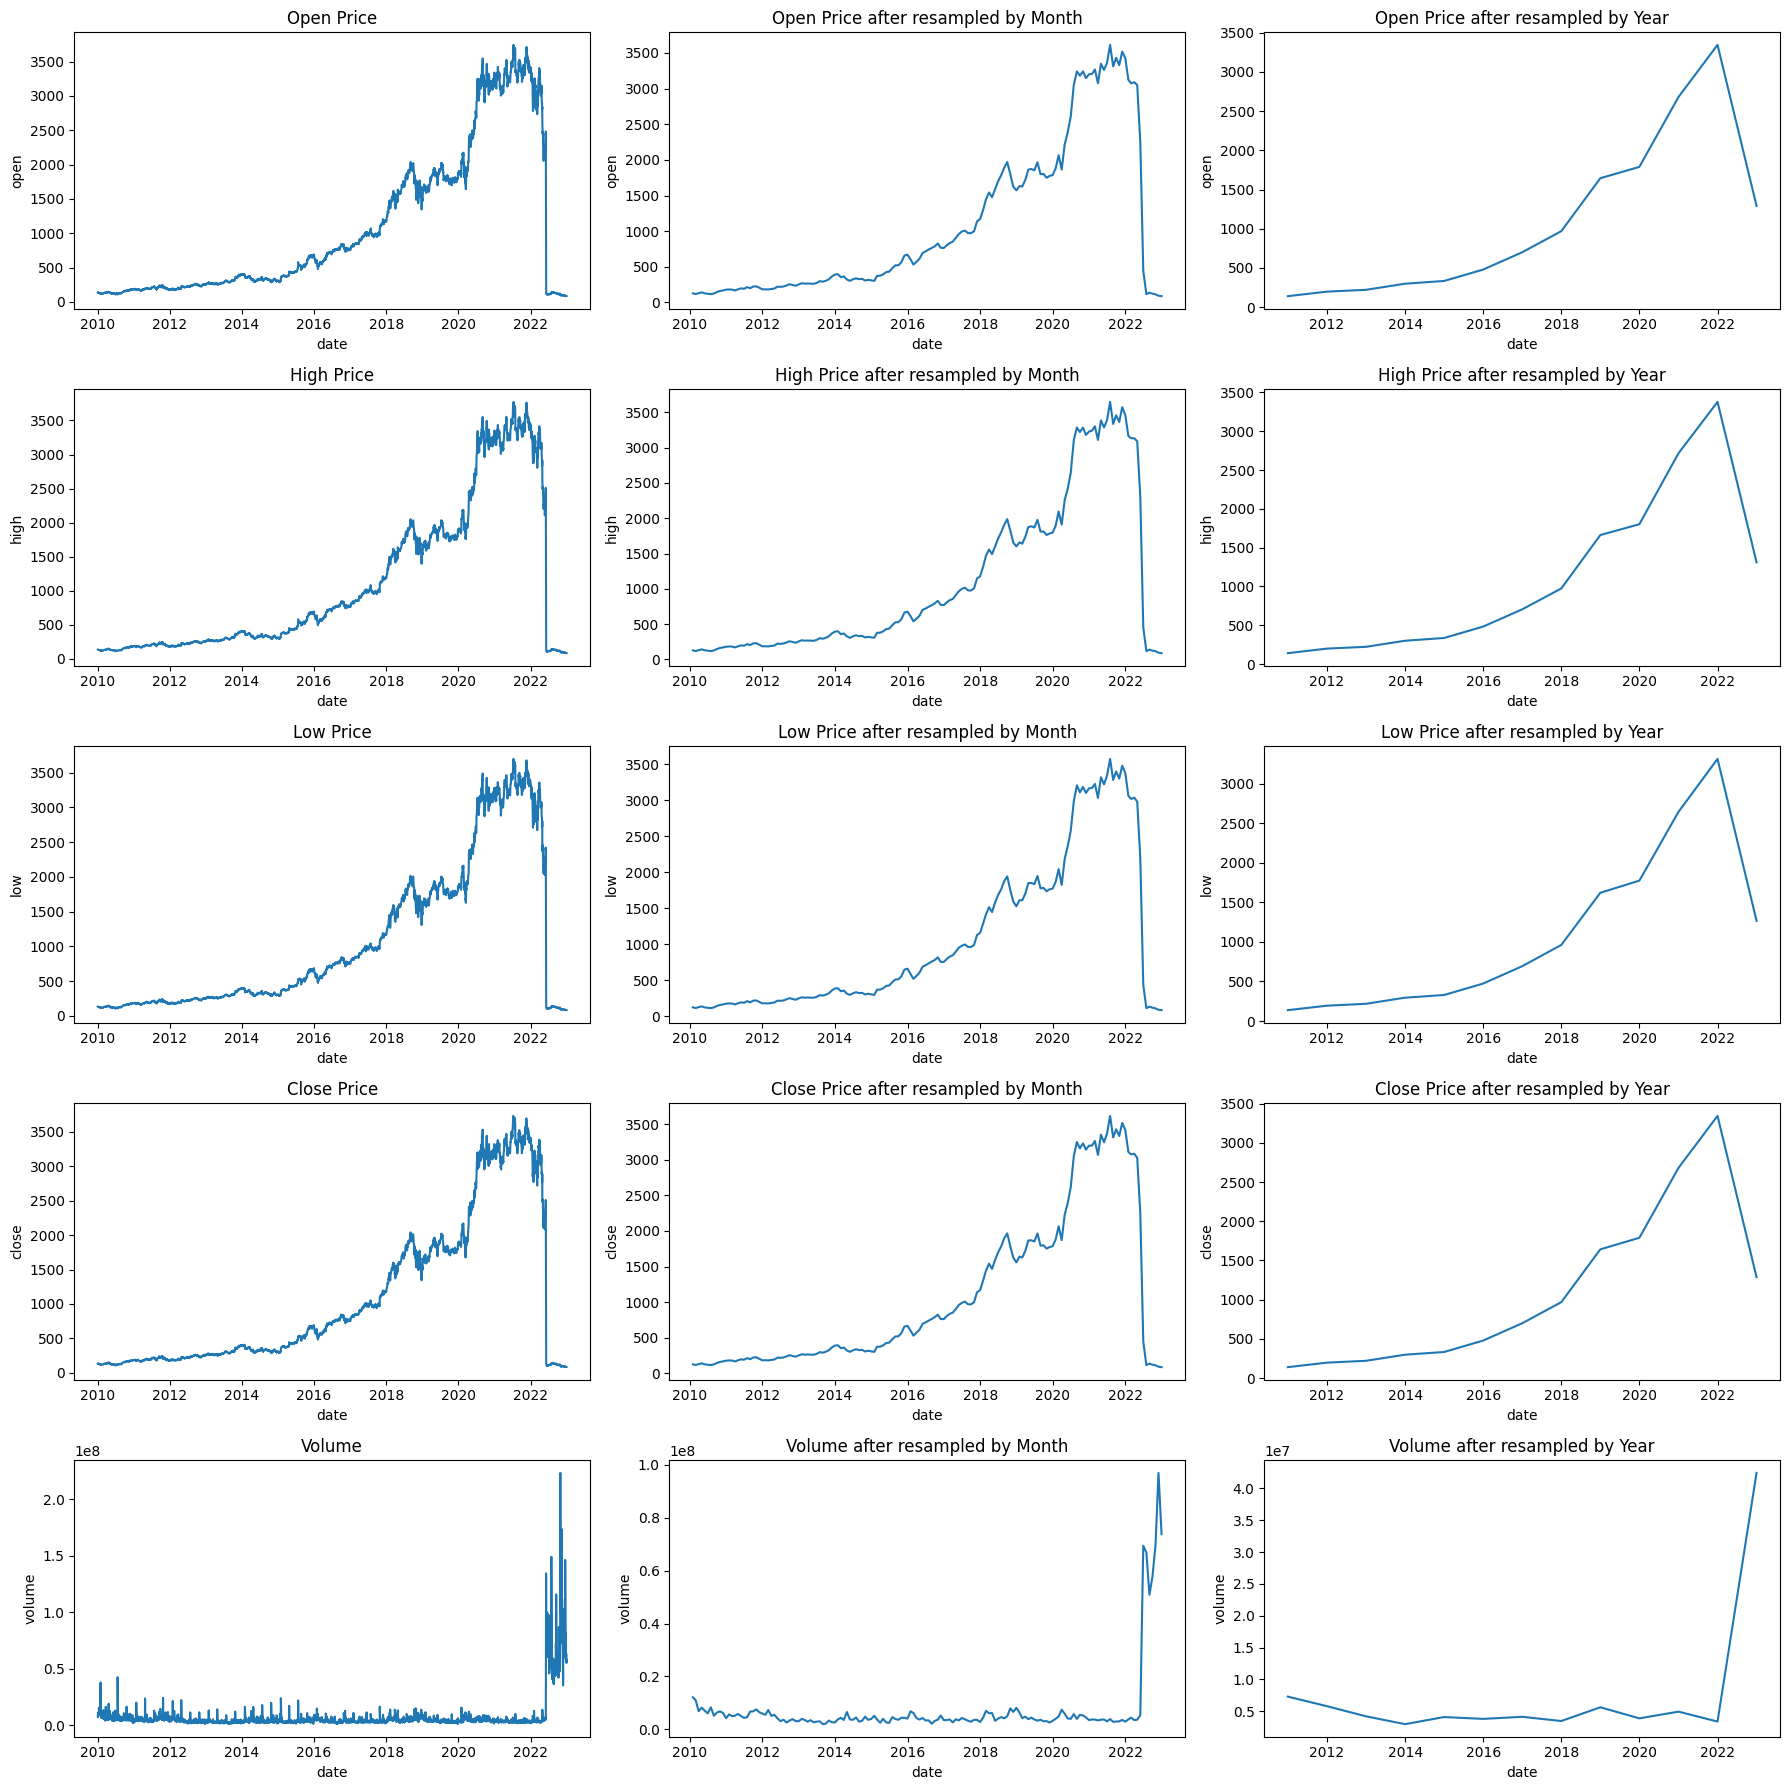

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=3,figsize=(18,18))
sns.lineplot(ax=axes[0,0], x=df.index,y=df.open).set_title("Open Price")
sns.lineplot(ax=axes[0,1], x=resampled_df.index,y=resampled_df.open).set_title("Open Price after resampled by Month")
sns.lineplot(ax=axes[0,2], x=resampled_df_d.index,y=resampled_df_d.open).set_title("Open Price after resampled by Year")

sns.lineplot(ax=axes[1,0], x=df.index,y=df.high).set_title("High Price")
sns.lineplot(ax=axes[1,1], x=resampled_df.index,y=resampled_df.high).set_title("High Price after resampled by Month")
sns.lineplot(ax=axes[1,2], x=resampled_df_d.index,y=resampled_df_d.high).set_title("High Price after resampled by Year")

sns.lineplot(ax=axes[2,0], x=df.index,y=df.low).set_title("Low Price")
sns.lineplot(ax=axes[2,1], x=resampled_df.index,y=resampled_df.low).set_title("Low Price after resampled by Month")
sns.lineplot(ax=axes[2,2], x=resampled_df_d.index,y=resampled_df_d.low).set_title("Low Price after resampled by Year")

sns.lineplot(ax=axes[3,0], x=df.index,y=df.close).set_title("Close Price")
sns.lineplot(ax=axes[3,1], x=resampled_df.index,y=resampled_df.close).set_title("Close Price after resampled by Month")
sns.lineplot(ax=axes[3,2], x=resampled_df_d.index,y=resampled_df_d.close).set_title("Close Price after resampled by Year")

sns.lineplot(ax=axes[4,0], x=df.index,y=df.volume).set_title("Volume")
sns.lineplot(ax=axes[4,1], x=resampled_df.index,y=resampled_df.volume).set_title("Volume after resampled by Month")
sns.lineplot(ax=axes[4,2], x=resampled_df_d.index,y=resampled_df_d.volume).set_title("Volume after resampled by Year")

plt.tight_layout()
plt.show()


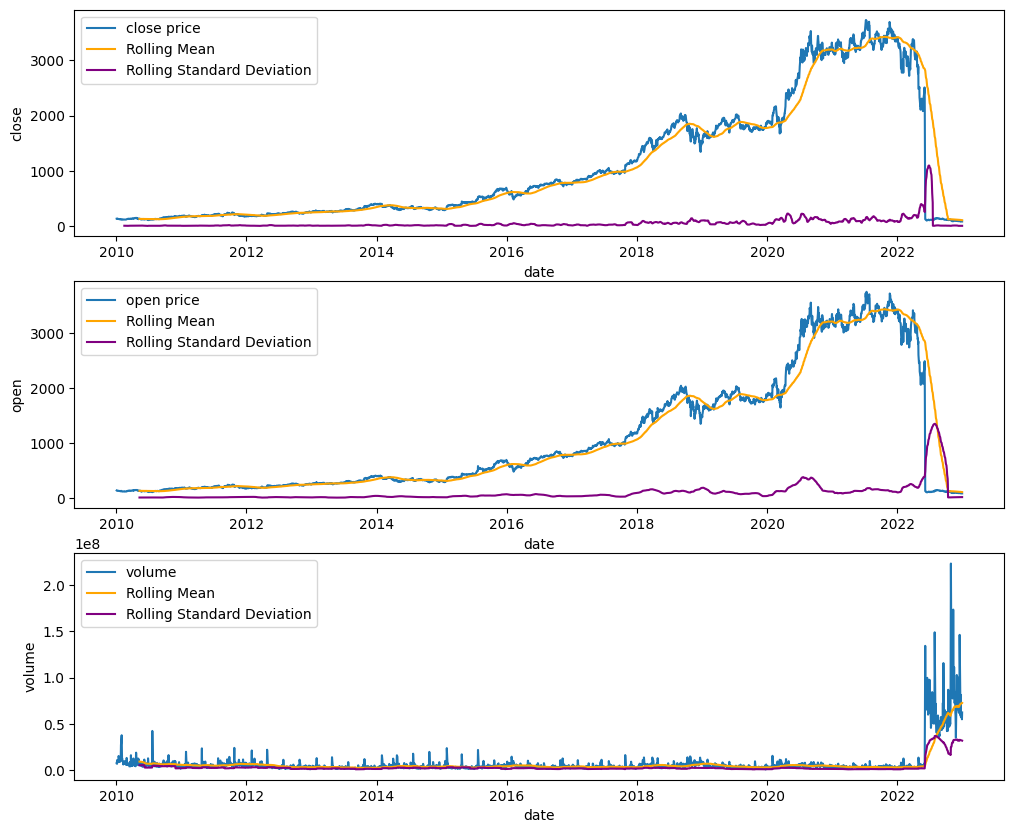

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(12,10))


sns.lineplot(x=df.index,y=df["close"], ax=axes[0], label='close price')
sns.lineplot(x=df.index,y=df['close'].rolling(90).mean(), ax=axes[0], label='Rolling Mean', color='orange')
sns.lineplot(x=df.index,y=df['close'].rolling(30).std(), ax=axes[0], label='Rolling Standard Deviation', color='purple')
axes[0].legend()


sns.lineplot(x=df.index,y=df["open"], ax=axes[1], label='open price')
sns.lineplot(x=df.index,y=df['open'].rolling(90).mean(), ax=axes[1], label='Rolling Mean', color='orange')
sns.lineplot(x=df.index,y=df['open'].rolling(90).std(), ax=axes[1], label='Rolling Standard Deviation', color='purple')
axes[1].legend()

sns.lineplot(x=df.index,y=df["volume"], ax=axes[2], label='volume')
sns.lineplot(x=df.index,y=df['volume'].rolling(90).mean(), ax=axes[2], label='Rolling Mean', color='orange')
sns.lineplot(x=df.index,y=df['volume'].rolling(90).std(), ax=axes[2], label='Rolling Standard Deviation', color='purple')
axes[2].legend()

plt.show()

In [9]:
df

,open,high,low,close,volume
date,,,,,
2010-01-04,136.25,136.610,133.1400,133.90,7599900.0
2010-01-05,133.43,135.479,131.8100,134.69,8851900.0
2010-01-06,134.60,134.730,131.6500,132.25,7178800.0
2010-01-07,132.01,132.320,128.8000,130.00,11030200.0
2010-01-08,130.56,133.680,129.0300,133.52,9830500.0
...,...,...,...,...,...
2022-12-23,83.25,85.780,82.9344,85.25,57433655.0
2022-12-27,84.97,85.350,83.0000,83.04,57284035.0
2022-12-28,82.80,83.480,81.6900,81.82,58228575.0


## Implementing Lag Feature

In [10]:
df['update_open'] = df['open'].shift(1)
df['update_high'] = df['high'].shift(1)
df['update_low'] = df['low'].shift(1)
df['update_close'] = df['close'].shift(1)
df['update_volume'] = df['volume'].shift(1)

In [11]:
df.head()

,open,high,low,close,volume,update_open,update_high,update_low,update_close,update_volume
date,,,,,,,,,,
2010-01-04,136.25,136.610,133.14,133.90,7599900.0,NaN,NaN,NaN,NaN,NaN
2010-01-05,133.43,135.479,131.81,134.69,8851900.0,136.25,136.610,133.14,133.90,7599900.0
2010-01-06,134.60,134.730,131.65,132.25,7178800.0,133.43,135.479,131.81,134.69,8851900.0
2010-01-07,132.01,132.320,128.80,130.00,11030200.0,134.60,134.730,131.65,132.25,7178800.0
2010-01-08,130.56,133.680,129.03,133.52,9830500.0,132.01,132.320,128.80,130.00,11030200.0


## Filling NaN values

In [12]:
df.update_close.fillna(df.close.iloc[1:3].mean(), inplace=True)
df.update_high.fillna(df.high.iloc[1:3].mean(), inplace=True)
df.update_low.fillna(df.low.iloc[1:3].mean(), inplace=True)
df.update_open.fillna(df.open.iloc[1:3].mean(), inplace=True)
df.update_volume.fillna(df.volume.iloc[1:8].mean(), inplace=True)

/var/folders/5r/8jpxvt3s2m1cz_nm5k_xb8tm0000gn/T/ipykernel_16320/109213357.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.update_close.fillna(df.close.iloc[1:3].mean(), inplace=True)
/var/folders/5r/8jpxvt3s2m1cz_nm5k_xb8tm0000gn/T/ipykernel_16320/109213357.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [13]:
df

,open,high,low,close,volume,update_open,update_high,update_low,update_close,update_volume
date,,,,,,,,,,
2010-01-04,136.25,136.610,133.1400,133.90,7599900.0,134.015,135.1045,131.7300,133.47,9.355757e+06
2010-01-05,133.43,135.479,131.8100,134.69,8851900.0,136.250,136.6100,133.1400,133.90,7.599900e+06
2010-01-06,134.60,134.730,131.6500,132.25,7178800.0,133.430,135.4790,131.8100,134.69,8.851900e+06
2010-01-07,132.01,132.320,128.8000,130.00,11030200.0,134.600,134.7300,131.6500,132.25,7.178800e+06
2010-01-08,130.56,133.680,129.0300,133.52,9830500.0,132.010,132.3200,128.8000,130.00,1.103020e+07
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,83.25,85.780,82.9344,85.25,57433655.0,85.520,85.6800,82.2500,83.79,8.143131e+07
2022-12-27,84.97,85.350,83.0000,83.04,57284035.0,83.250,85.7800,82.9344,85.25,5.743366e+07
2022-12-28,82.80,83.480,81.6900,81.82,58228575.0,84.970,85.3500,83.0000,83.04,5.728404e+07


## Droping 

In [14]:
df.drop(["open","high","low","volume"],axis=1,inplace=True)

In [15]:
df

,close,update_open,update_high,update_low,update_close,update_volume
date,,,,,,
2010-01-04,133.90,134.015,135.1045,131.7300,133.47,9.355757e+06
2010-01-05,134.69,136.250,136.6100,133.1400,133.90,7.599900e+06
2010-01-06,132.25,133.430,135.4790,131.8100,134.69,8.851900e+06
2010-01-07,130.00,134.600,134.7300,131.6500,132.25,7.178800e+06
2010-01-08,133.52,132.010,132.3200,128.8000,130.00,1.103020e+07
...,...,...,...,...,...,...
2022-12-23,85.25,85.520,85.6800,82.2500,83.79,8.143131e+07
2022-12-27,83.04,83.250,85.7800,82.9344,85.25,5.743366e+07
2022-12-28,81.82,84.970,85.3500,83.0000,83.04,5.728404e+07


## Spliting dataset

In [16]:
start_date="2010-01-04"
end_date="2020-12-31"
test_start_date="2021-01-04"
test_end_date="2022-12-30"


train_data=df[start_date:end_date]
test_data=df[test_start_date:test_end_date]

In [17]:
train_data

,close,update_open,update_high,update_low,update_close,update_volume
date,,,,,,
2010-01-04,133.90,134.015,135.1045,131.730,133.47,9.355757e+06
2010-01-05,134.69,136.250,136.6100,133.140,133.90,7.599900e+06
2010-01-06,132.25,133.430,135.4790,131.810,134.69,8.851900e+06
2010-01-07,130.00,134.600,134.7300,131.650,132.25,7.178800e+06
2010-01-08,133.52,132.010,132.3200,128.800,130.00,1.103020e+07
...,...,...,...,...,...,...
2020-12-24,3172.69,3205.000,3210.1300,3184.170,3185.27,2.093787e+06
2020-12-28,3283.96,3193.900,3202.0000,3169.000,3172.69,1.451917e+06
2020-12-29,3322.00,3194.000,3304.0000,3172.690,3283.96,5.620728e+06


## Normalization

In [18]:
# Normalisation
sc = MinMaxScaler()
train_d = sc.fit_transform(train_data)
test_d=sc.fit_transform(test_data)

In [19]:
print(train_d.shape,test_d.shape)

(2769, 6) (503, 6)


In [20]:
test_d

array([[8.50728438e-01, 8.71899924e-01, 8.67151849e-01, 8.73975123e-01,
        8.69990876e-01, 5.76600664e-03],
       [8.59463666e-01, 8.70534251e-01, 8.64191662e-01, 8.47093453e-01,
        8.50728438e-01, 1.23328285e-02],
       [8.37507775e-01, 8.42130995e-01, 8.51014075e-01, 8.52913481e-01,
        8.59463666e-01, 4.40383104e-03],
       ...,
       [0.00000000e+00, 5.92701846e-04, 5.06830256e-04, 3.62368662e-04,
        3.34284125e-04, 2.51085810e-01],
       [6.46647980e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.55351002e-01],
       [5.97327371e-04, 1.91194144e-05, 2.90004478e-04, 2.37890877e-04,
        6.46647980e-04, 2.40753419e-01]])

### Spliting features and target column

In [43]:
X, y = train_d[:, 1:], train_d[:, 0]

In [44]:
print(X.shape,y.shape)

(2769, 5) (2769,)


## Random Forest Training

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score
import pandas as pd

model = RandomForestRegressor(max_depth=20, max_features= 'sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42) #Seed -> help us to reproduce the model

# Train the model on the training data
model.fit(X, y)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)

## Predictions

In [46]:
def predictions(data,model):
    
    predict_value=[]
    for i in range(0,len(data)):
        a=data[i]
        a=a.reshape(1,data.shape[1])
        predict_value.append(model.predict(a))
        try:
            data[:,3][i+1]=predict_value[i][0]
        except:
            pass
    
    predict_value=np.array(predict_value)
    
    prdict_value=predict_value.reshape(predict_value.shape[1],predict_value.shape[0])
    return data,predict_value

In [47]:
X_test,y_test=test_d[:, 1:], test_d[:, 0]
print(X_test.shape,y_test.shape)

(503, 5) (503,)


## Training data preparing for XGBoost

In [48]:
# Use Random Forest predictions as features for XGBoost
RF_train,rf_predictions_train = predictions(X,model)#updated close price with predicted close price also predicted value
RF_test,rf_predictions_test = predictions(X_test,model)#updated close price with predicted close price also predicted value

since we use RF prediction data as a feature for our XGB booster model so we have to maintain the shape as our orginal data 

In [49]:
y_xgb=np.reshape(rf_predictions_train,y.shape[0])
y_test_xgb=np.reshape(rf_predictions_test,y_test.shape[0])

In [50]:
print(RF_train.shape,y_xgb.shape,RF_test.shape,y_test_xgb.shape)

(2769, 5) (2769,) (503, 5) (503,)


In [51]:
# Combine original features with Random Forest predictions
X_train_XGB = np.column_stack((RF_train, y_xgb))
X_test_XGB = np.column_stack((RF_test, y_test_xgb))

## XGBoost Training

In [52]:
# Train XGBoost regressor with Random Forest predictions as features
xgb_regressor = xgb.XGBRegressor(colsample_bytree= 0.8, gamma= 0.1, learning_rate= 0.05, max_depth= 5, min_child_weight= 5,
                                 n_estimators= 200, reg_alpha= 0, reg_lambda= 0, subsample= 1.0)
# 'max_depth': 7,5
# 'gamma': 0,0.1
# 'min_child_weight': 3,5
xgb_regressor.fit(X_train_XGB, y) # we fit the model with updated feature(X) and original target(y) value

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [53]:
# Evaluate XGBoost regressor with train dataset
updated_X_train,y_pred_train = predictions(X_train_XGB,xgb_regressor)
# Evaluate XGBoost regressor
updated_X_test,y_pred = predictions(X_test_XGB,xgb_regressor)

In [60]:
mse = mean_squared_error(y,y_pred_train)
print("Root Mean Squared Error of XGBoost regressor with Random Forest predictions as features:", sqrt(mse))

Root Mean Squared Error of XGBoost regressor with Random Forest predictions as features: 0.011607901147584065


In [61]:
mae = mean_absolute_error(y,y_pred_train)
print("Mean Absoulate Error of XGBoost regressor with Random Forest predictions as features:", mae)

Mean Absoulate Error of XGBoost regressor with Random Forest predictions as features: 0.006987649641747448


## we decompse our scaled data with our orginal data though our input already updated with new prediction value

### Rescaling Test Dataset

In [54]:
#prediction value rescaling for train data
inv_yhat_train = np.concatenate((y_pred_train, train_d[:, 1:]), axis=1)
inv_yhat_train = sc.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]

In [55]:
#prediction value rescaling for test data
inv_yhat = np.concatenate((y_pred, test_d[:, 1:]), axis=1)
inv_yhat = sc.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [56]:
#Rescaling data and picking the close price from the original dataset
inv_train = sc.inverse_transform(train_d)
inv_test = sc.inverse_transform(test_d)
inv_ytrain = inv_train[:,0]
inv_ytest = inv_test[:,0]

In [57]:
train_pred = pd.DataFrame()
train_pred=pd.DataFrame(train_pred, index=train_data.index)
train_pred["close"]=inv_ytrain
train_pred["train_predictions"]=inv_yhat_train

In [58]:
test = pd.DataFrame()
test=pd.DataFrame(test, index=test_data.index)
test["close"]=inv_ytest
test["test_predictions"]=inv_yhat

In [65]:
rmse_train = sqrt(mean_squared_error(train_pred["close"],train_pred["train_predictions"]))
mae_train=mean_absolute_error(train_pred["close"],train_pred["train_predictions"])
print('RMSE in Train: %.3f' % rmse_train)
print('MAE in Train: %.3f' % mae_train)

RMSE in Train: 42.364
MAE in Train: 25.502


In [66]:
rmse_test = sqrt(mean_squared_error(test["close"],test["test_predictions"]))
mae_test=mean_absolute_error(test["close"],test["test_predictions"])
print('RMSE in Test: %.3f' % rmse_test)
print('MAE in Test: %.3f' % mae_test)

RMSE in Test: 163.456
MAE in Test: 103.453


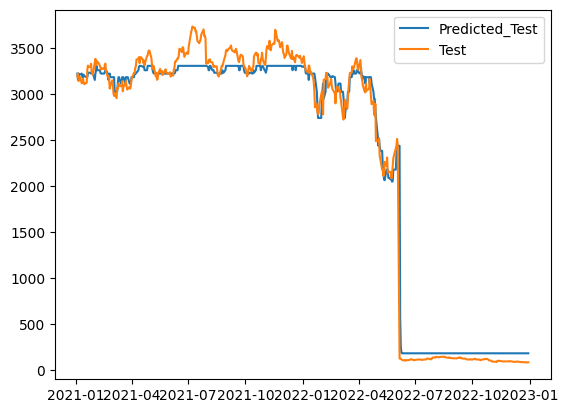

In [67]:
# line plot of observed vs predicted
plt.plot(test["test_predictions"])
plt.plot(test["close"])
plt.legend(["Predicted_Test","Test"])
plt.show()

In [137]:
from joblib import dump
dump(xgb_regressor, "RF+xgBoost_137.833.joblib")

['RF+xgBoost_137.833.joblib']

### Rescaling Train Dataset

In [46]:
# Plot the data
train = train_data["close"]
train=pd.DataFrame(train, index=train_data.index)

In [47]:
train_pred

,close,train_predictions
date,,
2010-01-04,108.785365,180.737874
2010-01-05,109.627700,180.737874
2010-01-06,107.026059,180.737874
2010-01-07,104.627005,180.737874
2010-01-08,108.380192,180.737874
...,...,...
2020-12-24,3348.883528,3134.954550
2020-12-28,3467.524738,3134.954550
2020-12-29,3508.084742,3134.954550


In [48]:
test

,close,test_predictions
date,,
2021-01-04,3186.63,3224.751755
2021-01-05,3218.51,3224.751755
2021-01-06,3138.38,3224.751755
2021-01-07,3162.16,3193.292638
2021-01-08,3182.70,3033.424294
...,...,...
2022-12-23,85.25,180.737874
2022-12-27,83.04,180.737874
2022-12-28,81.82,180.737874


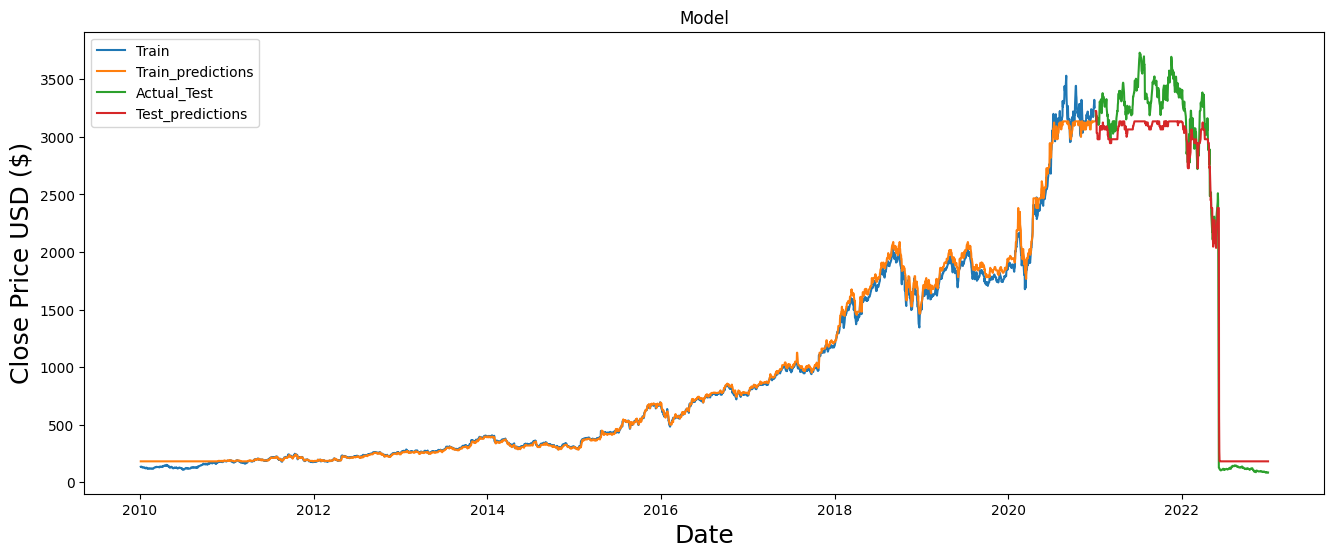

In [49]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train)
plt.plot(train_pred["train_predictions"])
plt.plot(test[['close','test_predictions']])
plt.legend(['Train','Train_predictions','Actual_Test', 'Test_predictions'], loc='upper left')
plt.show()

In [318]:
print(X_test[0][X_t=][:].shape)

(1, 5)


In [276]:
y_test[0]

1.0000000000000002

In [359]:
a=X_test[0]
a = a.reshape(a.shape[0], 1, a.shape[1])
a.shape
a.shape

(1, 1, 5)

In [339]:
X_te

SyntaxError: invalid syntax (4034144312.py, line 1)

In [355]:
a=X_test[250]

array([[2.10465550e-05, 3.19926327e-04, 2.62540908e-04, 7.09503438e-04,
        2.38816982e-01]])

In [356]:
X_test

array([[[9.91088287e-01, 9.87741141e-01, 9.92001661e-01, 9.77828018e-01,
         6.25230548e-04]],

       [[9.82633585e-01, 9.95834978e-01, 9.89571631e-01, 1.00000000e+00,
         4.29978364e-03]],

       [[1.00000000e+00, 1.00000000e+00, 9.90725590e-01, 9.82668274e-01,
         5.85169380e-03]],

       ...,

       [[6.52443204e-04, 5.59123581e-04, 3.99916964e-04, 3.66777201e-04,
         2.49175726e-01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.53451796e-01]],

       [[2.10465550e-05, 3.19926327e-04, 2.62540908e-04, 7.09503438e-04,
         2.38816982e-01]]])

In [389]:
print(y_test.shape[0])

251


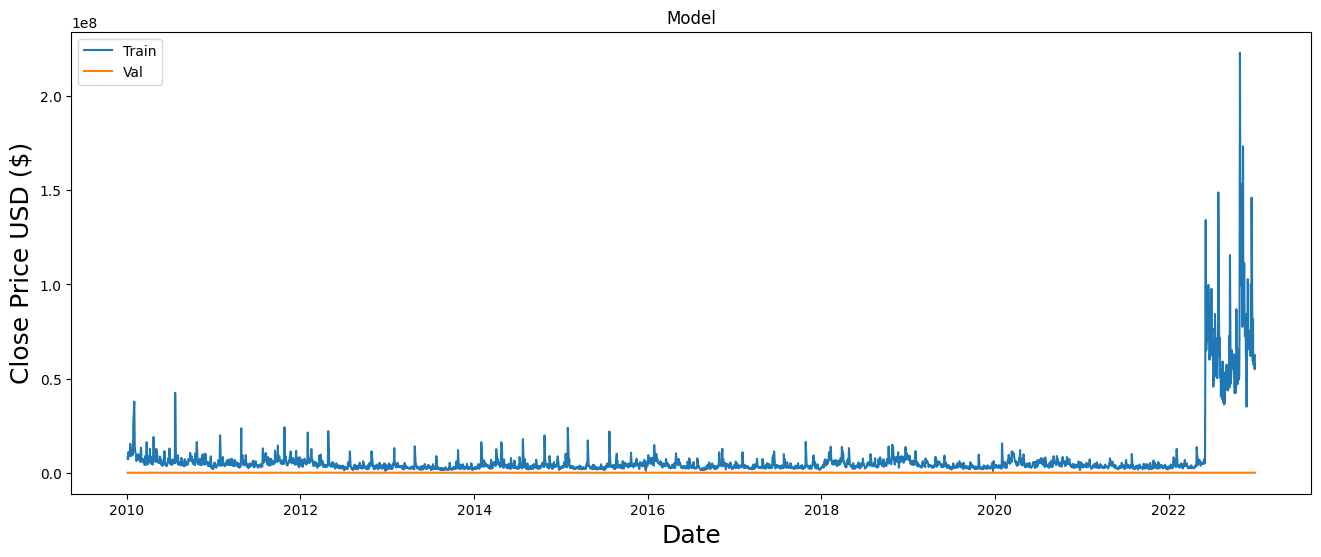

In [18]:
# Visualize the data
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(train)

plt.plot(df["volume"])
plt.plot(df["close"])
plt.legend(['Train', 'Val', 'Actual', 'Predictions'], loc='upper left')
plt.show()

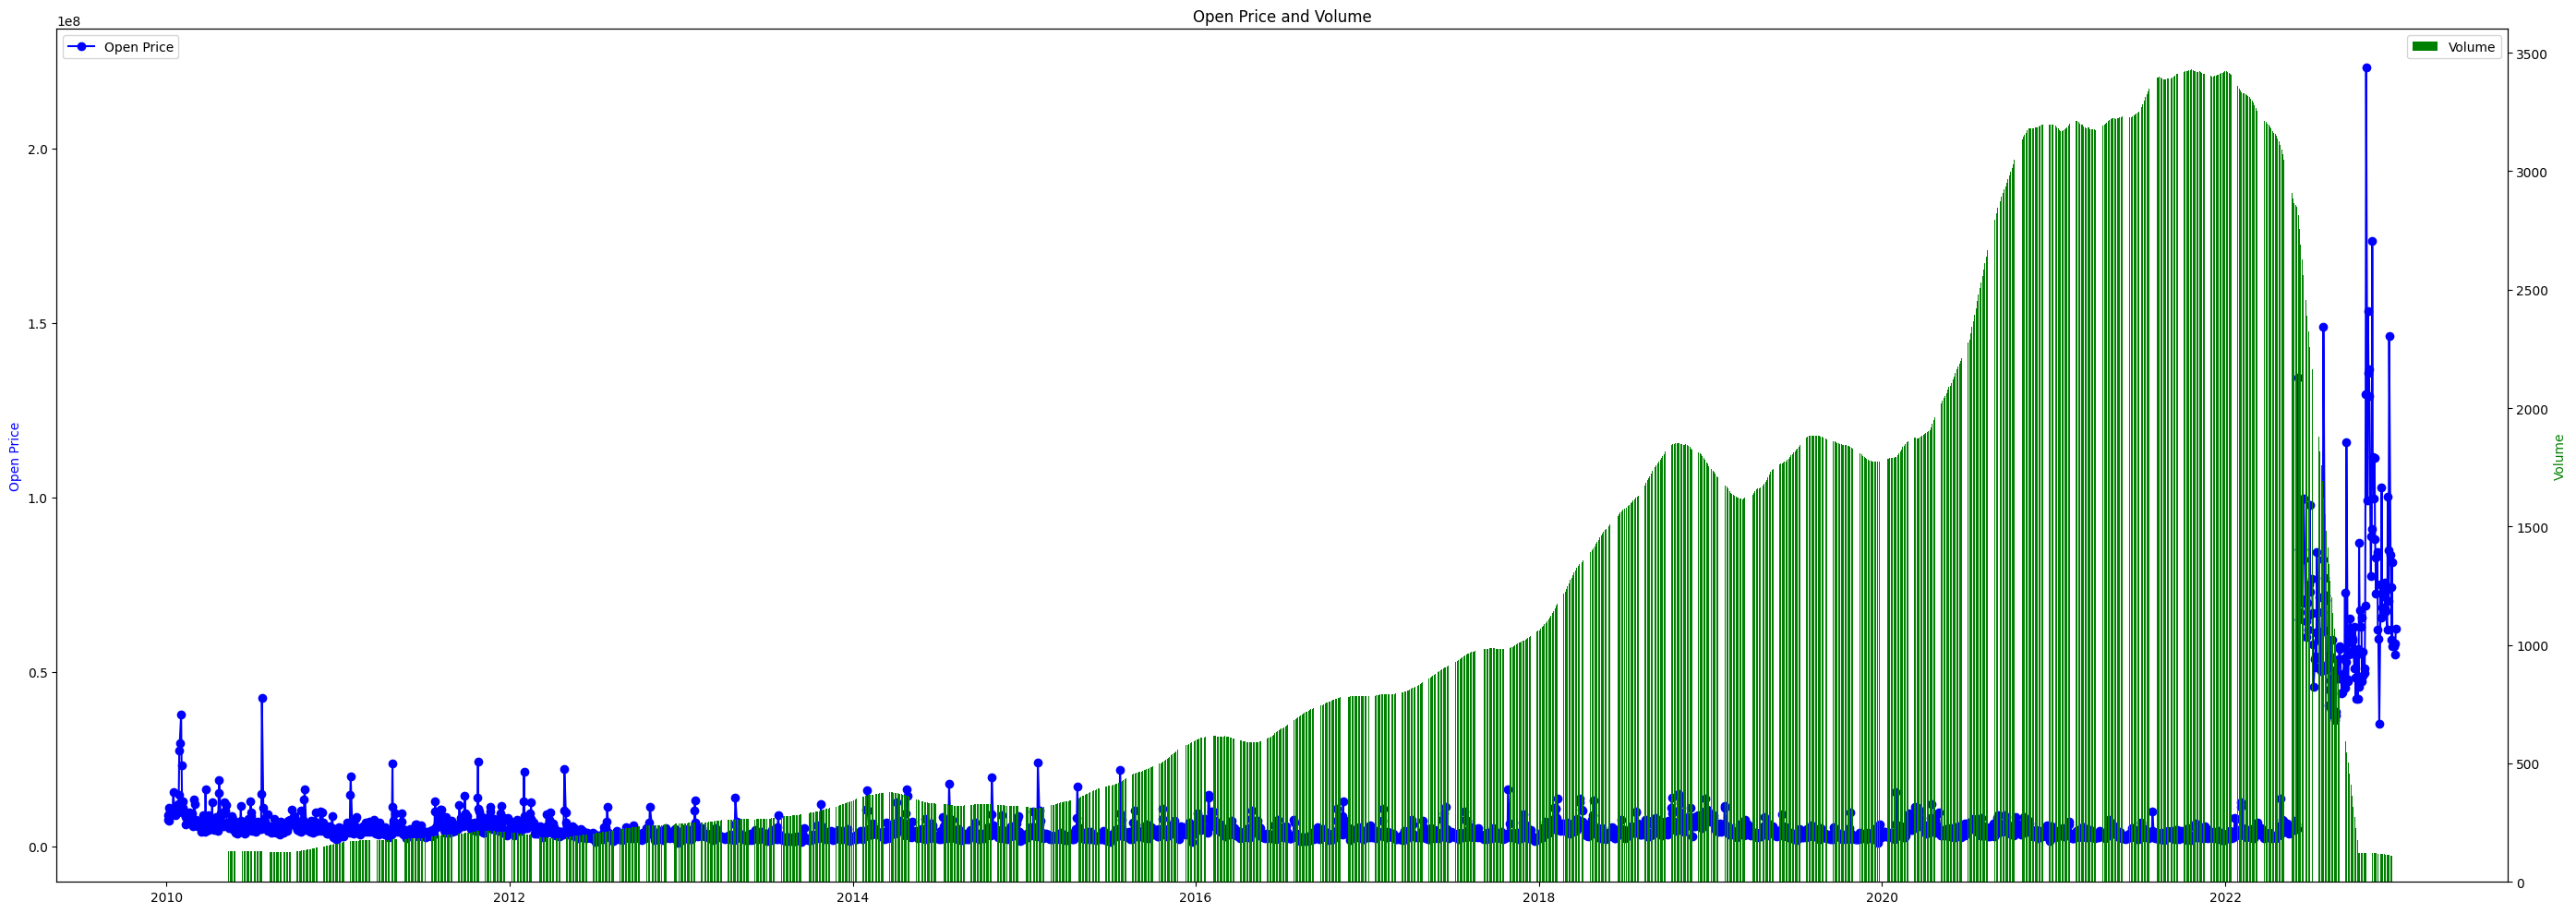

In [33]:
import matplotlib.pyplot as plt

# Example data
dates = df.index
open_prices = df.close.rolling(90).mean()
volumes = df.volume

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(28, 10))

# Plot open prices
ax1.plot(dates, volumes, color='blue', marker='o', label='Open Price')
ax1.set_ylabel('Open Price', color='blue')

# Create another y-axis for volume
ax2 = ax1.twinx()
ax2.bar(dates, open_prices, color='green', alpha=1, label='Volume')
ax2.set_ylabel('Volume', color='green')

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.title('Open Price and Volume')
plt.tight_layout()
plt.show()


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200, 300,400,500],
    'max_depth': [20,30,40],
    'min_samples_split': [5, 10,20],
    'min_samples_leaf': [2, 4,6],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42,64]
}

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor()

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring=mse_scorer, n_jobs=-1)
grid_search.fit(X, y)  # Assuming X_train and y_train are your training data

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}


In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200, 300,400,500],
    'max_depth': [20,30,40],
    'min_samples_split': [5, 10,20],
    'min_samples_leaf': [2, 4,6],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42,64]
}

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor()

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring=mse_scorer, n_jobs=-1)
grid_search.fit(X, y)  # Assuming X_train and y_train are your training data

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


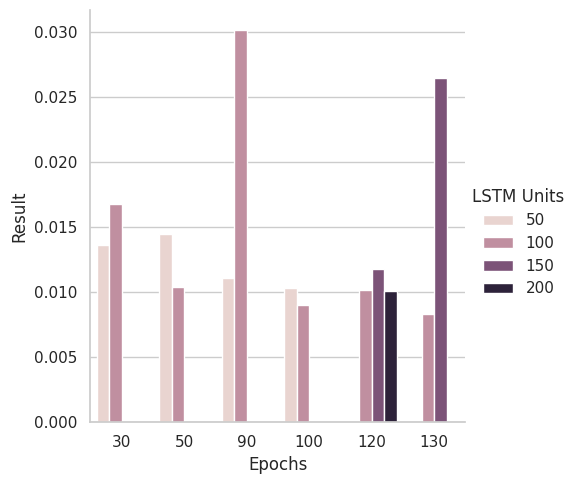

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Data
epochs = [30, 30, 50, 50, 90, 90, 100, 100, 120, 120, 120, 130, 130]
lstm_units = [50, 100, 50, 100, 50, 100, 50, 100, 100, 150, 200, 100, 150]
result = [0.0136, 0.0168, 0.0145, 0.0104, 0.0111, 0.0302, 0.0103, 0.0090, 0.0102, 0.0118, 0.0101, 0.0083, 0.0265]

# Data as DataFrame
data = {
    'Epochs': epochs,
    'LSTM Units': lstm_units,
    'Result': result
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Plot
sns.set(style="whitegrid")
g = sns.catplot(x="Epochs", y="Result", hue="LSTM Units", kind="bar", data=df, height=5, aspect=1)
g.set_axis_labels("Epochs", "Result")
g.set_titles("{col_name}")
plt.show()
